# Project 2: Crystallography Image Processing
## Background Subtraction

## Introduction/Context

Crystallography, an interdisciplinary field primarily centered on the study of solid-state chemistry and physics, delves into various aspects of matter. The definition is defined as the experimental science of determining the arrangement of atoms in crystalline solids — fundamental both material science and solid-state physics [@1][@2]. 

Primary interest X-ray crystallography is initiated by physicists however, the impact of this field of research has far reaching impacts on chemistry, biology, minerology, and material science [@3].

A significant branch of this field, protein crystallography, and its use of X-rays, focus on unraveling the three-dimensional structure and interactions of proteins. About 85% of known protein structures have been discovered by this technique [@5].

Protein crystallography is crucially importatn for investigating the interaction mechanisms between the Sars-Cov2 virus and human cells [@7]. 

Exploring how various proteins within the human body respond to pharmaceuticals [@8], allowing scientists to see how drugs fit into protein structures, a critical for increasing drug efficiency. 

Moreover, X-ray crystallography as well as cryogenic electron microscopy have aided our understanding of photosynthesis by revealing the structure of photosynthetic proteins and complexes, and how these function in the energy transfer [@9]. 

To accurately determine the atomic and molecular structure of crystals of interest, the signal and noise must be differentiated effectively. This simply put is isolating the signal from the diffraction data. This diffraction data being the intensity values, contain various forms of noise and or interference which must be accounted for.

## Background: 

- `Intensity (I)`: refers to the intensity of the diffracted X-rays formally called Bragg peaks, and for image processing this is simply the displayed pixel values. These pixel values are the diffracted number of photons that are detected by the detector. This detector needs to build for this very purpose, namely sensitive enough to count the number of individual photons. 

- `Threshold/Peak Finding`: The first step is to find the peaks in an image. In this demonstration, a threshold value to search for peaks above this value will be determined before the analysis. Here, goal is to differntiate the signal of the diffraction peaks from the crystal, and the noise from the intensity values which can be attributed to interference, or water within the protein.

- `Indexing`: Assigning each unique three-dimensional index to a reflection within the dataset, using Miller indices (`h,k,l`). There is more to this, but its not the focus of this report. Will use `indexamajig` from CrystFEL [@11]

- `HDF5 Images`: When running `pattern_sim` from CrystFEL [@12], this generates simulated a diffraction images, from femtosecond pulses of X-rays from free electron laser [@12]. This function takes in the geometry file type of the detector (`.geom`), the protein cryal (`.pdb`) file, and the intensity file (`.hkl`) as necissary input arguments, and outputs an HDF5 image (`.h5`). Further specifications can be added such as `--no-noise`, which generates only the peak values. This is what is used in the program below, and outputted from the `.stream` file.

- `Stream file`: While indexing images with `indexamajig` from CrystFEL [@11], a "stream file" will be outputted with extension `.stream` which obtains information of the found peaks, for given parameters like indexing method, the geometry file, the unit cell parameters (a,b,c, α, β, γ), algorithm used, peak integration method, peak search parameters like the minimum and maximum number of photons, etc. [@11]
  
- `a, b, c, α, β, γ`: These are unit cell parameters which are simply the lengths (`a,b,c`) and the angles of the unit cell measured in degrees (` α, β, γ`). This is fundamental for determining the system and size of the crystal lattice, as well as the packing ratio of the protein in question. 

## Problem: Integration
The challenge in the process of "Integration" during data processing lies in accurately measuring the peak intensity values (`I`) of diffracted radiation in an image, while accounting for the spread of background noise (`σI`) across the image. 

*The critical task is to precisely estimate the peak values and their exact coordinates, considering the surrounding area of each peak, which comprises the background.* 

This produces a solution that can effectively distinguish the peak intensity from the background noise. One commonly adopted approach to address this problem is through two-dimensional integration, as implemented in this context. The success of this technique hinges on its ability to accurately isolate and measure the peak intensities amidst varying background noise levels.

## Dataset Description:

The dataset under consideration comprises both high and low-intensity images, originally produced for a different projet. Despite this, the analytical code for processing these images is noteworthy and interesting. The high-intensity image, designated as  `9_18_23_high_intensity_3e8keV-2.h5`, were created using identical parameters as the low-intensity image `9_18_23_low_intensity_3e7keV-1.h5` with the exception of the number of photons counted. This variation results in a direct correlation between the intensity values and the number of photons; as the photon count increases, so does the intensity, and vice versa.

The images themselves are represented as two-dimensional arrays, having dimensions of (4127, 4352). This size reflects the area of the detector in use, as specified in the associated `.geom` file.

In terms of coordinates, they are represented as `(fs, ss)`, and be thought of as your x and y coordinates of the detector area. For this purpose, the detector geometry is only 1 pannel spanning the entire area, meaning that there are not partitioned pannels, which create gaps and complicate the analysis. However, greater emphasis is placed on the crystallographic aspects, specifically the unit cell parameters, crystal symmetry, and orientation.

For the high-intensity images, the `nphotons` parameter is set to 3e8 kilo electron volts (keV), while for the low-intensity images, it is set at 3e7 keV. Notably, when the intensity threshold is varied, there is a significant reduction in the number of detectable peaks when transitioning from high to low-intensity images.

When the intensity threshold is set at 9000 keV, the analysis identifies approximately 45-50 peaks in the high-intensity images, in contrast to only 12-15 peaks in the low-intensity images. This discrepancy highlights the impact of photon count on peak detectability. The analysis will be done incrememtally using an increasing radius every iteration of `coorinate_menu` function.

## Enviornment Setup:





In [6]:
import os
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt

## Code Implementation: 

1. File Loading (`load_file_h5 function`): It checks for the existence of the specified file in the working directory and attempts to load it, handling potential errors during the process.

2. Classes for Data Processing:
    - `PeakThresholdProcessor`: Initializes with an array and a threshold value. It includes methods to set a new threshold value and to retrieve coordinates in the array that exceed this threshold.
  
    - `ArrayRegion`: Manages a region within an array, including setting the central coordinates of the peaks, the size of the region, and extracting a specific region based on these parameters.

3. Region Extraction (`extract_region` function): Utilizes `ArrayRegion` to extract a specific region from an image array, based on given coordinates and region size.

4. Coordinate Interaction (`coordinate_menu` function): Interactively processes user-selected coordinates of interest from an array. It involves displaying the region around the selected coordinates, calculating surrounding intensity, and visualizing results.

5. Building Coordinate Intensity (`build_coord_intensity` function): Constructs arrays of x, y coordinates, and corresponding intensity values, based on coordinates above a specified threshold.

6. Scatter Plot Creation (`create_scatter` function): Generates and displays a 3D scatter plot of the coordinates with their respective intensities. It also highlights a specific point if provided.

7. Main Process (`main` function): Orchestrates the script’s workflow, including file loading, image array creation, threshold processing, and interactive coordinate analysis. It includes a detailed analysis of the intensity peaks and averages for different radii, providing estimates for each. Note that the radius exapands so the estimated peak can become more accurate the larger the radius.

8. Script Execution: The script is designed to execute with a main guard, processing an image file path defined within the script.

In [7]:
class PeakThresholdProcessor: 
    def __init__(self, array, threshold_value=0):
        self.array = array
        self.threshold_value = threshold_value
    def set_threshold_value(self, new_threshold_value):
        self.threshold_value = new_threshold_value
    def get_coordinates_above_threshold(self):  
        coordinates = np.argwhere(self.array > self.threshold_value)
        return coordinates
    
class ArrayRegion:
    def __init__(self, array):
        self.array = array
        self.x_center = 0
        self.y_center = 0
        self.region_size = 0
    def set_peak_coordinate(self, x, y):
        self.x_center = x
        self.y_center = y
    def set_region_size(self, size):
        #limit that is printable in terminal
        self.region_size = size
        max_printable_region = min(self.array.shape[0], self.array.shape[1]) //2
        self.region_size = min(size, max_printable_region)
    def get_region(self):
        x_range = slice(self.x_center - self.region_size, self.x_center + self.region_size+1)
        y_range = slice(self.y_center - self.region_size, self.y_center + self.region_size+1)
        region = self.array[x_range, y_range]
        return region

Images directory: /Users/adamkurth/Documents/vscode/CXFEL_Image_Analysis/CXFEL/waterbackground_subtraction/images
Image path: /Users/adamkurth/Documents/vscode/CXFEL_Image_Analysis/CXFEL/waterbackground_subtraction/images/9_18_23_high_intensity_3e8keV-2.h5

Loaded file successfully. /Users/adamkurth/Documents/vscode/CXFEL_Image_Analysis/CXFEL/waterbackground_subtraction/images/9_18_23_high_intensity_3e8keV-2.h5
Original threshold value:  10000 


Coordinates above given threshold: 1000 with radius:  1
1. (1551, 2150)
2. (1725, 1727)
3. (1731, 1729)
4. (1744, 1302)
5. (1851, 2453)
6. (1859, 1933)
7. (1860, 1933)
8. (1966, 1746)
9. (2310, 3305)
10. (2413, 2058)
11. (2536, 1226)
12. (2537, 1225)
13. (2570, 2565)
14. (3275, 2444)

Processing - (2537, 1225)
Printing 9x9 two-dimensional array

DISPLAY REGION 
 [[    0.0000095538     0.0000009666     0.0000029903     0.0001060178     0.0000016562     0.0000067189     0.0001324190     0.0002551888     0.0002032315]
 [    0.0000575081     0.000

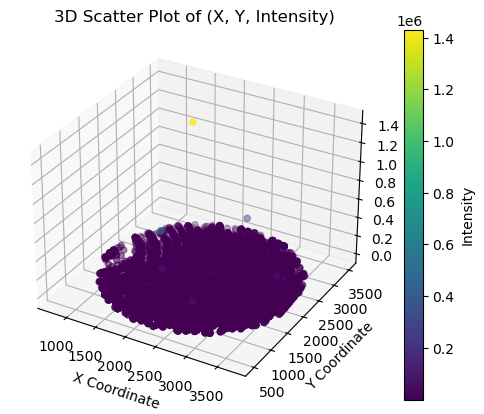

Peak Estimate for ring 1 : 48060.2265625 with radius of 1

Coordinates above given threshold: 1000 with radius:  2
1. (1551, 2150)
2. (1725, 1727)
3. (1731, 1729)
4. (1744, 1302)
5. (1851, 2453)
6. (1859, 1933)
7. (1860, 1933)
8. (1966, 1746)
9. (2310, 3305)
10. (2413, 2058)
11. (2536, 1226)
12. (2537, 1225)
13. (2570, 2565)
14. (3275, 2444)

Processing - (2537, 1225)
Printing 9x9 two-dimensional array

DISPLAY REGION 
 [[    0.0000095538     0.0000009666     0.0000029903     0.0001060178     0.0000016562     0.0000067189     0.0001324190     0.0002551888     0.0002032315]
 [    0.0000575081     0.0000733259     0.0015679249     0.0000803500     0.0000299185     0.0005925751     0.0005232695     0.0028475476     0.0038270673]
 [    0.0018070452     0.0022032850     0.0005983522     0.0001327770     0.0016767448     0.0072900783     1.3903557062     0.0306941979     0.0260324497]
 [    0.0069607357     0.0108417841     6.8102936745     0.0095064659     0.1665324718 18957.9238281250   41

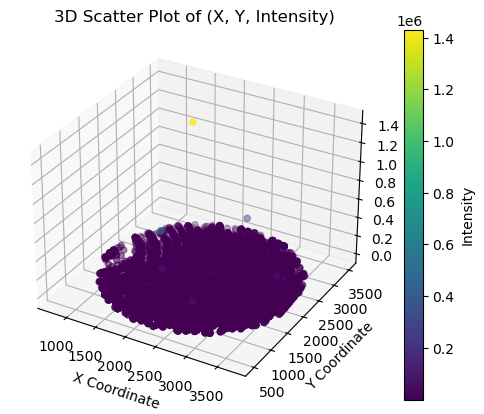

Peak Estimate for ring 2 : 48042.49929855094 with radius of 2

Coordinates above given threshold: 1000 with radius:  3
1. (1551, 2150)
2. (1725, 1727)
3. (1731, 1729)
4. (1744, 1302)
5. (1851, 2453)
6. (1859, 1933)
7. (1860, 1933)
8. (1966, 1746)
9. (2310, 3305)
10. (2413, 2058)
11. (2536, 1226)
12. (2537, 1225)
13. (2570, 2565)
14. (3275, 2444)

Processing - (2537, 1225)
Printing 9x9 two-dimensional array

DISPLAY REGION 
 [[    0.0000095538     0.0000009666     0.0000029903     0.0001060178     0.0000016562     0.0000067189     0.0001324190     0.0002551888     0.0002032315]
 [    0.0000575081     0.0000733259     0.0015679249     0.0000803500     0.0000299185     0.0005925751     0.0005232695     0.0028475476     0.0038270673]
 [    0.0018070452     0.0022032850     0.0005983522     0.0001327770     0.0016767448     0.0072900783     1.3903557062     0.0306941979     0.0260324497]
 [    0.0069607357     0.0108417841     6.8102936745     0.0095064659     0.1665324718 18957.9238281250 

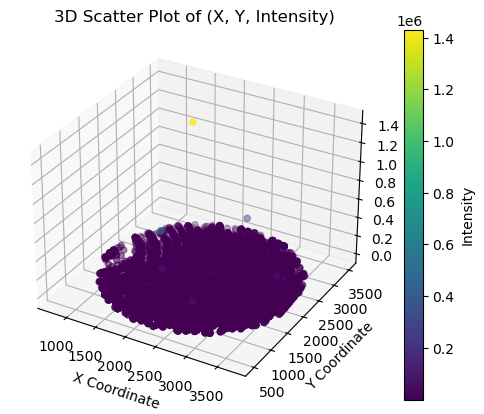

Peak Estimate for ring 3 : 48050.43855121541 with radius of 3

Coordinates above given threshold: 1000 with radius:  4
1. (1551, 2150)
2. (1725, 1727)
3. (1731, 1729)
4. (1744, 1302)
5. (1851, 2453)
6. (1859, 1933)
7. (1860, 1933)
8. (1966, 1746)
9. (2310, 3305)
10. (2413, 2058)
11. (2536, 1226)
12. (2537, 1225)
13. (2570, 2565)
14. (3275, 2444)

Processing - (2537, 1225)
Printing 9x9 two-dimensional array

DISPLAY REGION 
 [[    0.0000095538     0.0000009666     0.0000029903     0.0001060178     0.0000016562     0.0000067189     0.0001324190     0.0002551888     0.0002032315]
 [    0.0000575081     0.0000733259     0.0015679249     0.0000803500     0.0000299185     0.0005925751     0.0005232695     0.0028475476     0.0038270673]
 [    0.0018070452     0.0022032850     0.0005983522     0.0001327770     0.0016767448     0.0072900783     1.3903557062     0.0306941979     0.0260324497]
 [    0.0069607357     0.0108417841     6.8102936745     0.0095064659     0.1665324718 18957.9238281250 

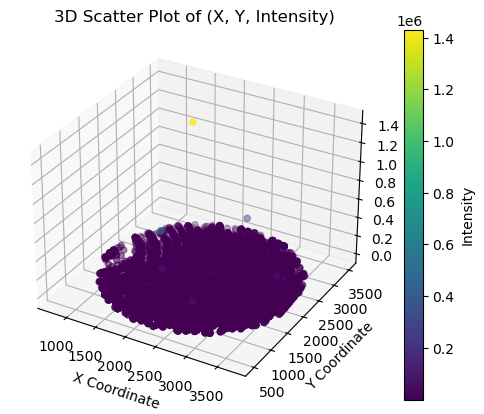

Peak Estimate for ring 4 : 48054.11782049901 with radius of 4


In [8]:

def load_file_h5(filename):
    if not os.path.exists(filename):
        print("File not found within working directory.")
        return
    try:
        with h5.File(filename, "r") as f: 
            print("\nLoaded file successfully.", filename)
    except Exception as e:
        print("\nAn error has occurred:", str(e))

   
def extract_region(image_array, region_size, x_center, y_center):
    extract = ArrayRegion(image_array)
    extract.set_peak_coordinate(x_center,y_center)
    extract.set_region_size(region_size)
    np.set_printoptions(floatmode='fixed', precision=10)
    np.set_printoptions(edgeitems=3, suppress=True, linewidth=200)
    region = extract.get_region()
    return region        
    
def coordinate_menu(image_array, threshold_value, coordinates, radius): 
    print("\nCoordinates above given threshold:", threshold_value, 'with radius: ', radius)
    for i, (x, y) in enumerate(coordinates):
        print(f"{i + 1}. ({x}, {y})")
    
    while True:
        choice = input("\nWhich coordinate do you want to process? (or 'q' to quit)\n")
        if choice == "q":
            print("Exiting")
            break
        try: 
            count = int(choice)-1
            if 0 <= count < len(coordinates):
                x,y = coordinates[count]
                print(f"\nProcessing - ({x}, {y})")
                print('Printing 9x9 two-dimensional array\n')
                
                #creates visualization if the array, of chosen peak
                display_region = extract_region(image_array, region_size=4, x_center=x, y_center=y)
                print('DISPLAY REGION \n', display_region, '\n')
                
                #segment is the area with the given radius that's passed through the function.
                segment = extract_region(image_array, region_size=radius, x_center=x, y_center=y)
                print ('SEGMENT \n', segment, '\n')
                
                #returns boolean array of traversed values.
                bool_square = np.zeros_like(segment, dtype=bool)
                print('BOOLEAN', '\n', bool_square, '\n') 

                values_array = extract_region(image_array, region_size=radius, x_center=x, y_center=y)
                
                global avg_values, intensity_peak
                total_sum = 0; skipped_point = None; count = 0; intensity_peak = 0
                for col_index in range(values_array.shape[0]):
                    for row_index in range(values_array.shape[1]):
                        if values_array[row_index, col_index] >= 0:
                            count += 1
                            bool_square[row_index, col_index] = True
                            if row_index == radius and col_index == radius:
                                skipped_point = (row_index, col_index)  
                                intensity_peak = values_array[row_index, col_index]
                                print(f'Peak point to be skipped: ({row_index}, {col_index}) ', values_array[radius,radius])
                            elif abs(row_index - radius) <= 1 and abs(col_index - radius) <=1:
                                print(f'Passed (row, col) ({row_index}, {col_index})', values_array[row_index,col_index])
                                pass
                            else:
                                print(f'(row,col) ({row_index}, {col_index}) with a value of ', values_array[row_index, col_index])
                                total_sum += values_array[row_index, col_index]
                print('\n######################')
                print(bool_square)
                print('Number of traversed cells', count)
                print('Peak point to be skipped:', skipped_point)
                print('Total sum:',total_sum)
                avg_values = total_sum / count
                print('Average surrounding peak:',avg_values)
                build_coord_intensity()
                create_scatter(result_x, result_y, result_z, highlight_x=x, highlight_y=y)
                return avg_values,intensity_peak
                break
            else: 
                print("Invalid coordinate idex.")
        except ValueError:
            print("Invalid input. Enter a number of 'q' to quit.")

def build_coord_intensity():
    global result_x, result_y, result_z, coordinates_and_intensities
    result_z = []
    threshold = PeakThresholdProcessor(image_array, threshold_value=.01)
    coord_above_threshold = threshold.get_coordinates_above_threshold()
    coord_above_threshold = np.array(coord_above_threshold)
    
    for i in coord_above_threshold: 
        result_x = coord_above_threshold[:,0]
        result_y = coord_above_threshold[:,1]
    
    result_x = np.array(result_x)
    result_y = np.array(result_y)
    
    for i in range(len(coord_above_threshold)):
        x = result_x[i]
        y = result_y[i]
        z = image_array[x,y]
        result_z.append(z)
    # creating a coordinate and intensity array to store the values we want to plot.
    coordinates_and_intensities = np.column_stack((result_x, result_y, result_z))
    return result_x, result_y, result_z, coordinates_and_intensities

def create_scatter(x, y, z, highlight_x=None, highlight_y=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    scatter = ax.scatter(coordinates_and_intensities[:, 0], coordinates_and_intensities[:, 1], coordinates_and_intensities[:,2], c=z, cmap='viridis', marker='o')

    highlight_z = image_array[highlight_x,highlight_y]
    print("Intensity value", highlight_z, "\n")

    if highlight_x is not None and highlight_y is not None:
        ax.scatter([highlight_x], [highlight_y], [highlight_z], c='red', marker='x', s=100, label='Highlighted Point')

    cbar = plt.colorbar(scatter)
    cbar.set_label('Intensity')
    
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Intensity')
    plt.title('3D Scatter Plot of (X, Y, Intensity)')
    plt.show()
    return None

def main(filename):
    load_file_h5(filename)
    global image_array
    image_array = None
    image = h5.File(filename, "r") 
    image_array = None
    with h5.File(filename, "r") as f:
        dset = image["entry/data/data"][()]
        image_array = np.array(dset)
        image_array_size = dset.shape
        image.close()
        
    """ 3 RING INTEGRATION """
    
    threshold = PeakThresholdProcessor(image_array, threshold_value=10000)
    print ("Original threshold value: ", threshold.threshold_value, "\n")
    global coordinates
    coordinates = threshold.get_coordinates_above_threshold()

    radius = [1,2,3,4]
    completed = False
    build_coord_intensity()
    while not completed:
        for r in radius:
            coordinate_menu(image_array, 1000, coordinates, r)
            intensity = intensity_peak; avg = avg_values
            spot_estimate_peak = intensity - avg
            print("Peak Estimate for ring", r, ":", spot_estimate_peak, 'with radius of', r)
        completed = True

if __name__ == "__main__":
    script_path = 'src/project_2.ipynb'
    # parent_dir = 'src'
    # print("Script path:", script_dir)
    # images_dir = os.path.join(parent_dir, "waterbackground_subtraction/images")
    # print("Images directory:", images_dir)
    images_dir = os.path.join("../images")
    images_dir = os.path.abspath(images_dir)
    print("Images directory:", images_dir)  
    image_path1 = os.path.join(images_dir, "9_18_23_high_intensity_3e8keV-2.h5")
    print("Image path:", image_path1)
    main(image_path1)
    # main(image_path2)

## Stream Adaptation

- Stream Adaptation: is designed to process and analyze data from the specified stream files. Recall that these simulations were run with no noise set as an option, to ensure that the code accurately assessed the peaks above the threshold. The differences in functions are below from the first image viewer.
  - `load_stream`: takes a stream path as input and reads the stream file and extracts the necessary data and storing it in a dictionary, called `data_columns`. 
  - `main`: This function takes a stream file path as input, loading the stream file, creates an intensity array, and performs 3 ring integration on the data. This then estimates the peak for each ring, except for radius at index 0, since this usually is ignored.

In [9]:

class PeakThresholdProcessor: 
    def __init__(self, image_array, threshold_value=0):
        self.image_array = image_array
        self.threshold_value = threshold_value
    def set_threshold_value(self, new_threshold_value):
        self.threshold_value = new_threshold_value
    def get_coordinates_above_threshold(self):  
        coordinates = np.argwhere(self.image_array > self.threshold_value)
        return coordinates
    
class ArrayRegion:
    def __init__(self, array):
        self.array = array
        self.x_center = 0
        self.y_center = 0
        self.region_size = 0
    def set_peak_coordinate(self, x, y):
            self.x_center = x
            self.y_center = y

    def set_region_size(self, size):
        #limit that is printable in terminal
        self.region_size = size
        max_printable_region = min(self.array.shape[0], self.array.shape[1]) //2
        self.region_size = min(size, max_printable_region)
    def get_region(self):
        x_range = slice(self.x_center - self.region_size, self.x_center + self.region_size+1)
        y_range = slice(self.y_center - self.region_size, self.y_center + self.region_size+1)
        region = self.array[x_range, y_range]
        return region

In [10]:
def extract_region(image_array, region_size, x_center, y_center):
    extract = ArrayRegion(image_array)
    extract.set_peak_coordinate(x_center,y_center)
    extract.set_region_size(region_size)
    np.set_printoptions(floatmode='fixed', precision=10)
    np.set_printoptions(edgeitems=3, suppress=True, linewidth=200)
    region = extract.get_region()
    return region      
    
def coordinate_menu(image_array, threshold_value, coordinates, radius): 
    print("\nCoordinates above given threshold:", threshold_value, 'with radius: ', radius)
    for i, (x, y) in enumerate(coordinates):
        print(f"{i + 1}. ({x}, {y})")
        
    while True:
        choice = input("\nWhich coordinate do you want to process? (or 'q' to quit)\n")
        if choice == "q":
            print("Exiting")
            break
        try: 
            count = int(choice)-1
            if 0 <= count < len(coordinates):
                x,y = coordinates[count]
                print(f"\nProcessing - ({x}, {y})")
                print('Printing 9x9 two-dimensional array\n')
                
                #creates visualization if the array, of chosen peak
                print(x,y)
                display_region = extract_region(image_array, region_size=4, x_center=x, y_center=y)
                
                print('DISPLAY REGION \n', display_region, '\n')
                
                #segment is the area with the given radius that's passed through the function.
                segment = extract_region(image_array, region_size=radius, x_center=x, y_center=y)
                print ('SEGMENT \n', segment, '\n')
                
                #returns boolean array of traversed values.
                bool_square = np.zeros_like(segment, dtype=bool)
                print('BOOLEAN: before traversing.', '\n', bool_square, '\n') 
            
                """ 3 RING INTEGRATION"""
                values_array = extract_region(image_array, region_size=radius, x_center=x, y_center=y)

                global avg_values, intensity_peak
                total_sum = 0; skipped_point = None; count = 0; intensity_peak = 0
                #traverses through (i = row) , (j = column)
                for col_index in range(values_array.shape[0]):
                    for row_index in range(values_array.shape[1]):
                        if values_array[row_index, col_index] >= 0:
                            count += 1
                            bool_square[row_index, col_index] = True
                            if row_index == radius and col_index == radius:
                                skipped_point = (row_index, col_index)  
                                intensity_peak = values_array[row_index, col_index]
                                print(f'Peak point to be skipped: ({row_index}, {col_index}) ', values_array[radius,radius])
                            elif abs(row_index - radius) <= 1 and abs(col_index - radius) <=1:
                                print(f'Passed (row, col) ({row_index}, {col_index})', values_array[row_index,col_index])
                                pass
                            else:
                                print(f'(row,col) ({row_index}, {col_index}) with a value of ', values_array[row_index, col_index])
                                total_sum += values_array[row_index, col_index]
                                
                print('\n######################')
                print(bool_square)
                print('Number of traversed cells', count)
                print('Peak point to be skipped:', skipped_point)
                print('Total sum:',total_sum)
                if count > 0:
                    avg_values = total_sum / count
                else: 
                    avg_values = "Could not divide by 0."
                print('Average surrounding peak:',avg_values)
                print('Peak point:', intensity_peak)
                return avg_values,intensity_peak
                break
            else: 
                print("Invalid coordinate idex.")
        except ValueError:
            print("Invalid input. Enter a number of 'q' to quit.")

def load_stream(stream_path):
    global stream_coord
    global result_x, result_y, result_z
    stream_name = os.path.basename(stream_path)
    full_path = os.path.join(stream_path)
    
    try:
        stream = open(full_path, 'r') 
        print("\nLoaded file successfully.", stream_name, '\n')
    except Exception as e: 
        print("\nAn error has occurred:", str(e),'\n')
    
    reading_peaks = False
    reading_geometry = False
    reading_chunks = True 
    global data_columns
    data_columns = {
        'h':[], 'k':[], 'l':[],
        'I':[], 'sigmaI':[], 'peak':[], 'background':[],
        'fs':[],'ss':[], 'panel':[]
    }
    for line in stream:
        if reading_chunks:
           if line.startswith('End of peak list'):
               reading_peaks = False
           elif line.startswith("   h    k    l          I   sigma(I)       peak background  fs/px  ss/px panel"):
               reading_peaks = True
           elif reading_peaks:
                try:
                    elements = line.split()
                    data_columns['h'].append(int(elements[0]))
                    data_columns['k'].append(int(elements[1]))
                    data_columns['l'].append(int(elements[2]))
                    data_columns['I'].append(float(elements[3]))
                    data_columns['sigmaI'].append(float(elements[4]))
                    data_columns['peak'].append(float(elements[5]))
                    data_columns['background'].append(float(elements[6]))
                    data_columns['fs'].append(float(elements[7]))
                    data_columns['ss'].append(float(elements[8]))
                    data_columns['panel'].append(str(elements[9]))
                except:
                    pass
        elif line.startswith('----- End geometry file -----'):
            reading_geometry = False
        elif reading_geometry:   
            try:
                par, val = line.split('=')
                if par.split('/')[-1].strip() == 'max_fs' and int(val) > max_fs:
                    max_fs = int(val)
                elif par.split('/')[-1].strip() == 'max_ss' and int(val) > max_ss:
                    max_ss = int(val)
            except ValueError:
                pass
        elif line.startswith('----- Begin geometry file -----'):
            reading_geometry = True
        elif line.startswith('----- Begin chunk -----'):
            reading_chunks = True   
    result_x = data_columns['fs']; result_y = data_columns['ss']; result_z = data_columns['I']
    return data_columns, result_x, result_y, result_z
   
def main(stream_path):
    load_stream(stream_path)
    xmin, xmax = np.min(result_x), np.max(result_x)
    ymin, ymax = np.min(result_y), np.max(result_y)

    num_rows = int(xmax-xmin+1)
    num_cols = int(ymax-ymin+1)
    print(num_rows, num_cols)
    intensity_array = np.zeros((num_rows,num_cols))

    for x,y,z in zip(result_x,result_y,result_z):
        row = int(x - xmin)
        col = int(y - ymin)
        intensity_array[row,col] = z

    """ 3 RING INTEGRATION """
    
    threshold = PeakThresholdProcessor(intensity_array, threshold_value=10000)
    print ("Original threshold value: ", threshold.threshold_value, "\n")
    global coordinates
    coordinates = threshold.get_coordinates_above_threshold()
    
    radius = [1,2,3,4]
    completed = False
    while not completed:
        for r in radius:
            threshold = PeakThresholdProcessor(intensity_array, threshold_value=9000)
            coordinate_menu(intensity_array, threshold.threshold_value, coordinates, radius=r)
            intensity = intensity_peak; avg = avg_values
            spot_estimate_peak = intensity - avg
            print("Peak Estimate for ring", r, ":", spot_estimate_peak, 'with radius of', r)
        completed = True

if __name__ == "__main__":
    script_dir = 'src/project_2.ipynb'
    stream_dir = os.path.join('../high_low_stream')
    stream_dir = os.path.abspath(stream_dir)
    print("Working directory:", stream_dir)
    stream_path1 = os.path.join(stream_dir, "test_high.stream")
    main(stream_path1)
    stream_path2 = os.path.join(stream_dir, "test_low.stream")
    # main(stream_path2)


Working directory: /Users/adamkurth/Documents/vscode/CXFEL_Image_Analysis/CXFEL/waterbackground_subtraction/high_low_stream

Loaded file successfully. test_high.stream 

4127 4352
Original threshold value:  10000 


Coordinates above given threshold: 9000 with radius:  1
1. (1055, 2916)
2. (1364, 2116)
3. (1521, 2955)
4. (1656, 1307)
5. (1735, 1953)
6. (1834, 2648)
7. (1865, 2328)
8. (1922, 1845)
9. (1936, 2398)
10. (1972, 2530)
11. (1988, 2002)
12. (2000, 2455)
13. (2048, 2400)
14. (2188, 2293)
15. (2434, 2054)
16. (3297, 2298)

Processing - (2000, 2455)
Printing 9x9 two-dimensional array

2000 2455
DISPLAY REGION 
 [[    0.0000000000     0.0000000000     0.0000000000     0.0000000000     0.0000000000     0.0000000000     0.0000000000     0.0000000000     0.0000000000]
 [    0.0000000000     0.0000000000     0.0000000000     0.0000000000     0.0000000000     0.0000000000     0.0000000000     0.0000000000     0.0000000000]
 [    0.0000000000     0.0000000000     0.0000000000     0.0000

## Final Conclusions:
The 3-ring integration method is a significant technique used in the field of X-ray crystallography data analysis. This processes the diffraction peak intensities over three concentric rings, typically centered around the Bragg peaks in the diffraction pattern. This project is an example of how scientists can analyze the data from experiments and :

- Improve Accuracy: by integrating over these rings with increasing radii and thus improving the estimation of the actual diffraction intensity to analyze the protein in question.
  
- Noise reduction: this method helps to better estimate the signal from the noise, thus creating cleaner data, and more reliable inferences.
  
- Versitility: This program can be used in various applications instead of simulation data. One already implemented versitile aspect of this is the threshold processing class, which allows for images to find peaks above a threshold in question. One such thing to further develop is the setup geometry of the detector while analyzing images, and experiment conditions.

Nonetheless, this image processing tool will be a vital aspect of further research with in X-ray crystallography and leading further scientific discoveries towards the goals of understanding the nature of interactions of proteins—— therefore, discovering further intricacies of our world.

## References:

[@1] [Wikipedia. (2022). Crystallography.](https://en.wikipedia.org/wiki/Crystallography)

[@2] [Wikipedia. (2022). Solid-state physics.](https://en.wikipedia.org/wiki/Solid-state_physics)

[@3] [MDPI. (n.d.). Crystallography.](https://www.mdpi.com/journal/crystals/crystallography)

[@4] [Keen, D. A. (2014). Crystallography and physics. Physica Scripta, 89(12), 128003.](https://iopscience.iop.org/article/10.1088/0031-8949/89/12/128003)

[@5] [MDPI. (2015). Protein Crystallography in Vaccine Research and Development.](https://www.mdpi.com/1422-0067/16/6/13106)

[@6] [PubMed. (n.d.). Protein Structure Analysis and Validation with X-Ray Crystallography.](https://pubmed.ncbi.nlm.nih.gov/26428397/)

[@7] [NCBI. (n.d.). An Overview of the Crystallized Structures of the SARS-CoV-2.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7564894/)

[@8] [ScienceDirect. (n.d.). Crystallography and Drug Discovery.](https://www.sciencedirect.com/topics/chemistry/crystallography)

[@9] [AIP. (n.d.). Photosynthetic light harvesting and energy conversion.](https://pubs.aip.org/doi/10.1063/1.5139441)

[@10] [Harold R. Powell. (2021). A beginner’s guide to X-ray data processing.](https://doi.org/10.1042/bio_2021_124)

[@11] [T. White (n.d). CrystFEL manual: indexamajig](https://www.desy.de/~twhite/crystfel/manual-indexamajig.html)

[@12] [T. White (n.d). CrystFEL manual: pattern_sim](https://www.desy.de/~twhite/crystfel/manual-pattern_sim.html)
